$$\frac{\partial{\vec{u}}}{\partial{t}} + (\vec{u} \cdot \vec{\nabla}{\vec{u}})\vec{u} = -\frac{1}{\rho}\vec{\nabla}{p} + \nu\vec{\nabla}^2\vec{u} + \vec{g}$$

$p$: pressure
$u$: velocity
$\rho$: the fluids density
$\nu$: the kinematic viscosity given by: $\frac{\eta}{\rho}$, with $\eta$ being the viscosity
$g$: gravity experienced by the fluid

The fluid will be incompressible given by:
$$ \vec{\nabla} \cdot \vec{u} = 0 $$
This means the fluid density should remain constant

Similar to that of the example at https://www.youtube.com/watch?v=BQLvNLgMTQE, here we will solve the Navier-Stokes equation in 2D using Chorin's Projection method, with finite element method.

First, by solving the momentum part without the pressure gradient
Second, by solving the pressure poisson's equation
Third, by correcting the velocities using the solution to the poisson's equation



Latex extra stuff i might need later:

	%The unknowns one wishes to solve from the 2D Navier-Stokes is the velocity vector field $\vec{u}(x, y, t)$ and the pressure gradient $\vec{\nabla}p(x, y)$. This nonlinear partial differential equation has one time derivative and two spacial derivatives in $\vec{u}(x, y, t)$ followed by two spacial derivatives in $p(x, y)$. For the initial condition in time, we will assume the fluid is at rest everywhere at time $t=0$. This also means that the pressure in the fluid is $0$ everywhere. For the boundary conditions of $\vec{u}(x, y, t)$, the fluid should reflect off the container, thus one will apply homogeneous Dirichlet boundary conditions to the velocity vector field everywhere except the top of the cavity, where a second fluid will be driving the systems at some horizontal velocity. One will also enact homogeneous Neumann boundary conditions on the pressure gradient.
	

	\subsubsection{Solving the Momentum Equation}
	The first step in the analysis of the Navier Stokes is by using a technique called operator splitting. First one will solve for the temporal term and write it explicitly as some change in the velocity.
		\begin{equation}
			\frac{\vec{u}_{t+1} - \vec{u}_t}{\Delta t} = \frac{\partial{\vec{u}}}{\partial{t}} = -\frac{1}{\rho}\vec{\nabla}p + \nu\vec{\nabla}^2\vec{u}  - (\vec{u} \cdot \vec{\nabla})\vec{u}
		\end{equation}
	

	
	One then will split the time steps of the velocity into two parts, separated by some intermediate tentative velocity $\vec{u}^*$. This will result in two equations: the momentum part and the pressure gradient part. 
		\begin{equation}
			\frac{\vec{u}^* - \vec{u}_t}{\Delta t} =  \nu\vec{\nabla}^2\vec{u}  - (\vec{u} \cdot \vec{\nabla})\vec{u} 
		\end{equation}
		\begin{equation}
			\frac{\vec{u}_{t+1} - \vec{u}^*}{\Delta t} = -\frac{1}{\rho}\vec{\nabla}p
		\end{equation}
	In the first expression $(3.2)$, the tentative velocity is no longer incompressible due to the lack of the pressure term. The new unknown $\vec{u}^*$ will then be implicitly known and represented in the diffusing term, while $\vec{u}_t$ will be explicitly known in the convective term. One can then solve for the compressible tentative velocity.
		\begin{equation}
			\frac{\vec{u}^* - \vec{u}_t}{\Delta t} =  \nu\vec{\nabla}^2\vec{u}^*  - (\vec{u}_t \cdot \vec{\nabla})\vec{u}_t
		\end{equation}
	\subsubsection{Pressure Poisson's Equation}
	To remedy the incompressible tentative velocity, one will solve for the pressure by applying the divergence to $(3.3)$ resulting in a pressure poisson's equation.
	Because $u_{t+1}$ is still incompressible, the term will go to zero, and with the tentative velocity known one can solve for the pressure.
		\begin{equation}
			\frac{1}{\Delta t}(\vec{\nabla} \cdot \vec{u}^*) = \nabla^2p
		\end{equation}
	\subsubsection{Velocity Correction / Projection}
		Now with the pressure known, on can correct the tentative velcoity by projecting into a function space that is incompressible using $(3.3)$.
		The equations above represent the strong form of the convection problem. A weak form can also be determined by integration. The weak form will be applied to the numerical approach. 
		
	% oophf

"""
pu/pt + (u * grad)u = -1/ρ * grad_p + nu lap_u + f
incompressibility div u = 0

u:
p: pressure
f: forcing(this case = 0)
nu: kinemetic viscosity
ρ: density
t: time
grad: gradient (defining nonlinear convection)
lap: laplace operator

Lid driven scenario (2D with top of container has flow driving circular flow inside)
dirichlet boundary conditions (u = 0 and v = 0 on edges of container)

splitting method: Chorin's projection method:

1.) solve momentum without pressure gradient for tentative velocity
    pu/pt + (u * grad) =  nu lap_u

2.) solve pressure poisson eq:
    lap_p = rho/dt * grad * u

3.) correct velocities
    u < - u - dt/rho * grad_p

in 2D: in index notation u = [ux, uy], v = [vx, vy]
"""

[2, 3, 4, 5, 6, 7]


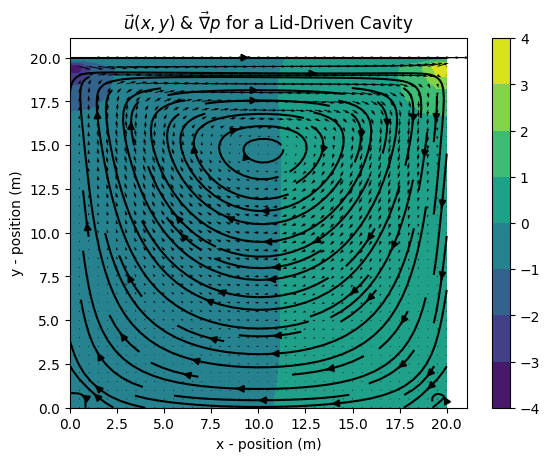

In [3]:
# Input Commands
N_POINTS = 41
DOMAIN_SIZE = 1.0 #
DOMAIN_SIZE_X = 20.0
DOMAIN_SIZE_Y = 60.0  # eddies in the corners forming the fluid in the corners is trapped by the cavity bounds forming eddies
N_ITERATION = 500
TIME_STEP_LENGTH = 0.001
KINEMATC_VISCOSITY = 0.1        # nu

# rho = 1, 10
# horizontal velcoty = 1, 10
# 4 total graphs, 1;1, 1;10, 10;1, 10;10
DENSITY = 1.0                   # rho and prop to pressure high rho high pressure, more mass more impact and more press
HORIZONTAL_VELOCITY_TOP = 1.0  # velocity prop to the pressure and the sink centering

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


def Navier_Stokes_Cavity(DENSITY, HORIZONTAL_VELOCITY_TOP, DOMAIN_SIZE_X, DOMAIN_SIZE_Y):
    element_length = DOMAIN_SIZE / (N_POINTS - 1)                # step size of each term
    x_array = np.linspace(0.0, DOMAIN_SIZE_X, N_POINTS)         # range of points for x values
    y_array = np.linspace(0.0, DOMAIN_SIZE_Y, N_POINTS)         # range of points for y values
    x_mesh, y_mesh = np.meshgrid(x_array, y_array)

    # initial conditions: fluid is at rest, no pressure, and zero velocities
    u_previous = np.zeros_like(x_mesh)  # velocity in x direction
    v_previous = np.zeros_like(y_mesh)  # velocity in y direction
    pressure_previous = np.zeros_like(x_mesh) # pressure at each coordinate initialy 0
    # len(x_mesh) = len(y_mesh)

    # Central Difference Method to solve for the Laplacian can lead to instability in diffusion...

    # scale factor*function - distence: (diagonal dominence)



    # Solving Poisson's Equation
    def central_difference_in_x(field):
        diffx = np.zeros_like(field)  # matrix/array of zeros with same dimensions as input field
        # exclude inputting values in the outer data points enacting the BC
        diffx[1:-1, 1:-1] = (
            field[1:-1, 2: ] - field[1:-1, 0:-2]
        ) / (
            2 * element_length
        )
        # the field is given by [y1:y2, x1:x2] the y terms remain the same [1:-1],
        # while the x terms go from [1 + 1:-1 + 1], and [1 - 1: -1 -1] ie advanced by one and
        # subtracted by 1 thus central difference
        return diffx
    def central_difference_in_y(field):
        # like diff in x, we do the same operation but on the [y:y] terms
        diffy = np.zeros_like(field)

        diffy[1:-1, 1:-1] = (
            field[2: , 1:-1] - field[0:-2, 1:-1]
        ) / (
            2 * element_length
        )
        # advanced by 1 and subtracted by 1 in y terms
        return diffy

    def laplacian(field):
        # 2D laplacian:
        lap = np.zeros_like(field)
        lap[1:-1, 1:-1] = (
             field[1:-1, 0:-2] + field[0:-2, 1:-1] - 4*field[1:-1, 1:-1] + field[1:-1, 2: ] + field[2: , 1:-1]
        ) / element_length**2
        return lap


    # stability factor
    maximum_possible_step_length = (0.5 * element_length**2/KINEMATC_VISCOSITY)
    # from the heat equation
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_step_length:
        raise RuntimeError('Stability not guaranteed')

    # accuracy of the field based on the number of iterations we do for the derivatives
    for _ in range(N_ITERATION):
        # get the partial derivatives for u_previous and v_previous in the x and y direction
        # recall u and v are mesh/grids ie matrices based on the x-y domain/ vector points
        d_u_prev__dx = central_difference_in_x(u_previous)
        d_u_prev__dy = central_difference_in_y(u_previous)
        d_v_prev__dx = central_difference_in_x(v_previous)
        d_v_prev__dy = central_difference_in_y(v_previous)

        # get the laplacian as well for both:
        lap__u_prev = laplacian(u_previous)
        lap__v_prev = laplacian(v_previous)


        # Calculate the Tentative Velocity by solving the momentum equation without the pressure gradient
        # Forward Difference Euler evolution
        u_tentative = (u_previous + TIME_STEP_LENGTH * (-(u_previous * d_u_prev__dx + v_previous * d_u_prev__dy)
                                                        + KINEMATC_VISCOSITY * lap__u_prev))
        v_tentative = (v_previous + TIME_STEP_LENGTH * (-(u_previous * d_v_prev__dx + v_previous * d_v_prev__dy)
                                                        + KINEMATC_VISCOSITY * lap__v_prev))
        # Apply the Dirichlet Boundary Conditions
        u_tentative[0, :] = 0.0  # bottom bound = 0: y = 0, all x
        u_tentative[:, 0] = 0.0  # left bound = 0: all y, x = 0
        u_tentative[:, -1] = 0.0 # right bound = 0: all y, x = last term
        u_tentative[-1, :] = HORIZONTAL_VELOCITY_TOP  # top bound unbounded: y = last term, all x

        v_tentative[0, :] = 0.0  # bottom bound = 0: y = 0, all x
        v_tentative[:, 0] = 0.0  # left bound = 0: all y, x = 0
        v_tentative[:, -1] = 0.0  # right bound = 0: all y, x = last term
        v_tentative[-1, :] = 0.0 # top bound =0: y = last term, all x

        # Pressure Correction: Divergence of u = 0
        d_u_tentative__dx = central_difference_in_x(u_tentative)
        d_v_tentative__dy = central_difference_in_y(v_tentative)

        # Compute Pressure Poisson Equation Neumann Method (approx to the liner system by smoothing)
        rhs = (DENSITY / TIME_STEP_LENGTH * (d_u_tentative__dx + d_v_tentative__dy))

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            pressure_next = np.zeros_like(pressure_previous)
            pressure_next[1:-1, 1:-1] = 1/4 * (+ pressure_previous[1:-1, 0:-2] + pressure_previous[0:-2, 1:-1]
                                               + pressure_previous[1:-1, 2: ] + pressure_previous[2: , 1:-1]
                                               - element_length**2*rhs[1:-1, 1:-1]) # interior pts (1/4 from 5pt stencil except center pt)
            # boundary conditions: Neumann BC derivative across the boundary is 0, which is the current value of the next pt
            pressure_next[:, -1] = pressure_next[:, -2]
            pressure_next[0, :] = pressure_next[1, :]
            pressure_next[:, 0] = pressure_next[:, 1]
            pressure_next[-1, :] = 0.0  # Dirichlet still

            pressure_previous = pressure_next  # update for loop

        # velocity correction we need the derivative of p
        d_p_next__dx = central_difference_in_x(pressure_next)
        d_p_next__dy = central_difference_in_y(pressure_next)

        # correction such that fluid stays incompressible
        u_next = (u_tentative - TIME_STEP_LENGTH / DENSITY * d_p_next__dx)
        v_next = (v_tentative - TIME_STEP_LENGTH / DENSITY * d_p_next__dy)

        # enforce boundary again
        u_next[0, :] = 0.0
        u_next[:, 0] = 0.0
        u_next[:, -1] = 0.0
        u_next[-1, :] = HORIZONTAL_VELOCITY_TOP

        v_next[0, :] = 0.0
        v_next[:, 0] = 0.0
        v_next[:, -1] = 0.0
        v_next[-1, :] = 0.0

        # time update
        u_previous = u_next
        v_previous = v_next
        pressure_previous = pressure_next

    plt.figure()
    plt.contourf(x_mesh, y_mesh, pressure_next) # for pressure
    plt.colorbar()

    plt.quiver(x_mesh, y_mesh, u_next, v_next, color='black')
    #plt.title(r'$\vec{u}(x, y)$ & $\vec{\nabla}p$ for a Lid-Driven Cavity')
    #plt.xlabel('x - position (m)')
    #plt.ylabel('y - position (m)')
    plt.streamplot(x_mesh, y_mesh, u_next, v_next, color='black')
    plt.title(r'$\vec{u}(x, y)$ & $\vec{\nabla}p$ for a Lid-Driven Cavity')
    plt.xlabel('x - position (m)')
    plt.ylabel('y - position (m)')
    plt.savefig('20x20_r1_u1')
    plt.show()

    return
# derivative

if __name__ == "__main__":
    #print(a[1:-1]) # [2, 3, 4, 5, 6, 7] ignores the boundary
    Navier_Stokes_Cavity(1, 1, 20, 20)

